In [ ]:
import pandas as pd
import numpy as np
import tejapi
import os
import json
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
tej_key = 'your key'
tejapi.ApiConfig.api_key = tej_key
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"
os.environ['TEJAPI_KEY'] = tej_key


from zipline.sources.TEJ_Api_Data import get_universe
import TejToolAPI
from zipline.data.run_ingest import simple_ingest
from zipline.api import set_slippage, set_commission, set_benchmark,  symbol,  record, order_target_percent
from zipline.finance import commission, slippage
from zipline import run_algorithm

In [2]:
start_date = '2010-01-01'; end_date = '2025-05-27'

pool = get_universe(start = start_date,
                      end = end_date,
                      mkt_bd_e = ['TSE', 'OTC'],
                      stktp_e = ['Common Stock-Foreign','Common Stock'])

columns = ['coid', 'Industry', 'roi', 'mktcap', 'r405', 'r403', 'per', 'r105', 'fld005']

start_dt = pd.Timestamp(start_date, tz = 'UTC')
end_dt = pd.Timestamp(end_date, tz = "UTC")

data_use = TejToolAPI.get_history_data(start = start_dt,
                                    end = end_dt,
                                    ticker = pool + ['IR0001'],
                                    fin_type = ['Q', 'TTM'], 
                                    columns = columns,
                                    transfer_to_chinese = False)

Currently used TEJ API key call quota 638/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 155177898/9223372036854775807 (0.0%)
Currently used TEJ API key call quota 811/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 168675904/9223372036854775807 (0.0%)


In [87]:
data_use.columns

Index(['coid', 'mdate', 'Industry', 'PER_TWSE', 'ROI', 'Market_Cap_Dollars',
       'Director_and_Supervisor_Holdings_Percentage',
       'Operating_Income_Growth_Rate_Q', 'Operating_Income_Growth_Rate_TTM',
       'Net_Income_Growth_Rate_Q', 'Net_Income_Growth_Rate_TTM',
       'Gross_Margin_Rate_percent_Q', 'Gross_Margin_Rate_percent_TTM',
       'avg_mkt', 'avg_ds_ratio', 'ind_gross_margin_mean', 'PEG'],
      dtype='object')

In [88]:
data_use = data_use.sort_values(['mdate', 'coid'])

data_use['avg_mkt'] = data_use.groupby('mdate')['Market_Cap_Dollars'].transform('mean')
data_use['avg_ds_ratio'] = data_use.groupby('mdate')['Director_and_Supervisor_Holdings_Percentage'].transform('mean')

data_use['ind_gross_margin_mean'] = data_use.groupby(['mdate', 'Industry'])['Gross_Margin_Rate_percent_Q'].transform('mean')

data_use['PEG'] = data_use['PER_TWSE'] / data_use['Operating_Income_Growth_Rate_TTM']

In [90]:
def compute_stock(date, data):
    df = data[data['mdate'] == pd.to_datetime(date)].reset_index(drop=True)

    set_1 = set(df[df['Market_Cap_Dollars'] <= df['avg_mkt'] * 0.3]['coid'])
    set_2 = set(df[df['Net_Income_Growth_Rate_Q'] >= 15]['coid'])
    set_3 = set(df[df['Gross_Margin_Rate_percent_TTM'] >= df['ind_gross_margin_mean']]['coid'])
    set_4 = set(df[df['Director_and_Supervisor_Holdings_Percentage'] > df['avg_ds_ratio']]['coid'])
    set_5 = set(df[df['PEG'] < 1.0]['coid'])

    passed = set_1 & set_2 & set_3  & set_5 & set_4

    top_n = int(len(passed) * 0.2)

    # 篩選出通過條件的股票
    filtered_df = df[df['coid'].isin(passed)]

    # 排序並取前 top_n 名（例如 PEG 最小）
    top_df = filtered_df.sort_values(by='PEG').head(top_n)
    
    tickers = list(top_df['coid'])

    sets = [len(set_1), len(set_2), len(set_3), len(set_4), len(set_5)]

    return tickers, sets


In [5]:
pools = pool + ['IR0001', 'IR0043']

start_ingest = start_date.replace('-', '')
end_ingest = end_date.replace('-', '')

print(f'開始匯入回測資料')
simple_ingest(name = 'tquant' , tickers = pools , start_date = start_ingest , end_date = end_ingest)
print(f'結束匯入回測資料')

開始匯入回測資料
Now ingesting data.


[2025-06-05 03:34:11.065783] INFO: zipline.data.bundles.core: Ingesting tquant.


Merging daily equity files:
Currently used TEJ API key call quota 819/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 186458522/9223372036854775807 (0.0%)


[2025-06-05 03:38:42.800879] INFO: zipline.data.bundles.core: Ingest tquant successfully.


End of ingesting tquant.
Please call function `get_bundle(start_dt = pd.Timestamp('20100101', tz = 'utc'),end_dt = pd.Timestamp('20250527' ,tz = 'utc'))` in `zipline.data.data_portal` to check data.
Currently used TEJ API key call quota 819/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 186458522/9223372036854775807 (0.0%)
結束匯入回測資料


Currently used TEJ API key call quota 1433/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 300485038/9223372036854775807 (0.0%)


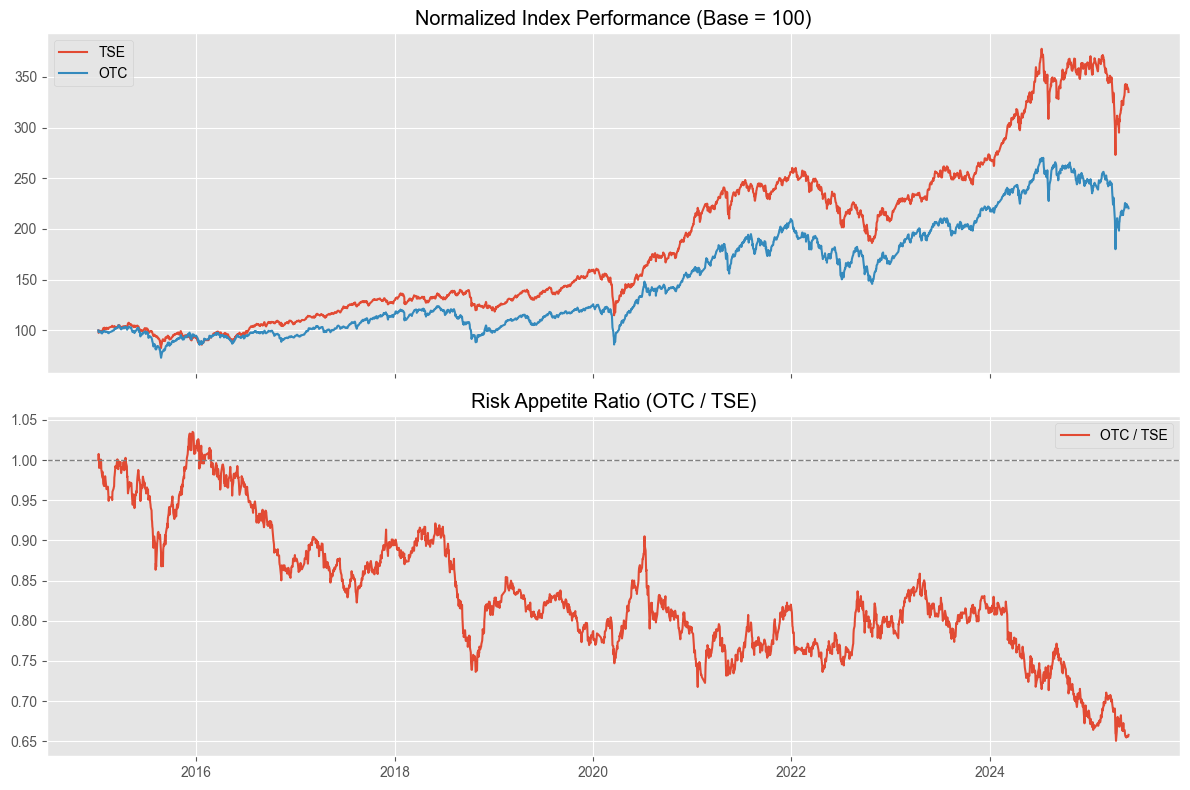

In [77]:
back_start = '2015-01-01'

codes = ['IR0001', 'IR0043']

co = ['coid','Industry', 'mkt', 'vol', 'open_d', 'high_d', 'low_d', 'close_d', 'roi', 'shares', 'per', 'pbr_tej','mktcap']
data_index = TejToolAPI.get_history_data(start = start_dt,
                                   end = end_dt,
                                   ticker = codes,
                                   columns = co,
                                   transfer_to_chinese = False)
# 篩選時間
data_index = data_index[data_index['mdate'] >= back_start]

# 分別取出 TSE 與 OTC 並標準化
tse = data_index[data_index['coid'] == 'IR0001'][['mdate', 'Close']].copy()
otc = data_index[data_index['coid'] == 'IR0043'][['mdate', 'Close']].copy()

tse.rename(columns={'Close': 'TSE_Close'}, inplace=True)
otc.rename(columns={'Close': 'OTC_Close'}, inplace=True)

# 合併（on mdate）
merged = pd.merge(tse, otc, on='mdate', how='inner')

# 標準化：以首日為基準
merged['TSE_norm'] = merged['TSE_Close'] / merged['TSE_Close'].iloc[0] * 100
merged['OTC_norm'] = merged['OTC_Close'] / merged['OTC_Close'].iloc[0] * 100

# 計算風險偏好比（OTC / TSE）
merged['OTC_TSE_ratio'] = merged['OTC_norm'] / merged['TSE_norm']

# 畫圖
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

axes[0].plot(merged['mdate'], merged['TSE_norm'], label='TSE')
axes[0].plot(merged['mdate'], merged['OTC_norm'], label='OTC')
axes[0].set_title('Normalized Index Performance (Base = 100)')
axes[0].legend()
axes[0].grid(True)

axes[1].plot(merged['mdate'], merged['OTC_TSE_ratio'], label='OTC / TSE')
axes[1].set_title('Risk Appetite Ratio (OTC / TSE)')
axes[1].axhline(1.0, color='gray', linestyle='--', linewidth=1)
axes[1].legend()
axes[1].grid(True)


plt.tight_layout()
plt.show()


In [91]:
def initialize(context, re = 20):
    set_slippage(slippage.VolumeShareSlippage(volume_limit=1, price_impact=0.01))
    set_commission(commission.Custom_TW_Commission())
    set_benchmark(symbol('IR0001'))

    context.i = 0
    context.state = False
    context.order_tickers = []
    context.last_tickers = []
    context.rebalance = re
    context.set1 = 0
    context.set2 = 0
    context.set3 = 0
    context.set4 = 0
    context.set5 = 0
    context.set = 0

    context.dic = {}

def handle_data_1(context, data):
    # 避免前視偏誤，在篩選股票下一交易日下單
    if context.state == True:

        for i in context.last_tickers:
            if i not in context.order_tickers:
                order_target_percent(symbol(i), 0)


        for i in context.order_tickers:
            order_target_percent(symbol(i), 1.0 / len(context.order_tickers))
            context.dic[i] = data.current(symbol(i), 'price')

        record(p = context.dic)
        context.dic = {}

        print(f"下單日期：{data.current_dt.date()}, 擇股股票數量：{len(context.order_tickers)}, Leverage: {context.account.leverage}")
        context.last_tickers = context.order_tickers.copy()
        context.state = False

    backtest_date = data.current_dt.date()

    if context.i % context.rebalance == 0:
        context.state = True
        context.order_tickers = compute_stock(date = backtest_date, data = data_use)[0]
        context.set = compute_stock(date = backtest_date, data = data_use)[1]


    record(tickers = context.order_tickers)
    record(Leverage = context.account.leverage)
    
    if context.account.leverage > 1.2:
        print(f'{data.current_dt.date()}: Over Leverage, Leverage: {context.account.leverage}')
        for i in context.order_tickers:
            order_target_percent(symbol(i), 1 / len(context.order_tickers))

    context.i += 1

下單日期：2015-01-06, 擇股股票數量：16, Leverage: 0.0
下單日期：2015-02-03, 擇股股票數量：17, Leverage: 0.9984368940846474
下單日期：2015-03-12, 擇股股票數量：17, Leverage: 1.0058772162216676
下單日期：2015-04-13, 擇股股票數量：17, Leverage: 1.003776305619513
下單日期：2015-05-12, 擇股股票數量：15, Leverage: 0.9996649952114771
下單日期：2015-06-09, 擇股股票數量：12, Leverage: 0.9967797215569484
下單日期：2015-07-08, 擇股股票數量：11, Leverage: 1.003578007700289
下單日期：2015-08-06, 擇股股票數量：12, Leverage: 0.9830737194477375
下單日期：2015-09-03, 擇股股票數量：12, Leverage: 0.9952636018080933
下單日期：2015-10-05, 擇股股票數量：11, Leverage: 1.0018382055298318
下單日期：2015-11-03, 擇股股票數量：11, Leverage: 1.0004857005916885
下單日期：2015-12-01, 擇股股票數量：17, Leverage: 1.0017870903099995
下單日期：2015-12-29, 擇股股票數量：17, Leverage: 1.005610978706719
下單日期：2016-01-27, 擇股股票數量：17, Leverage: 1.0018606875624838
下單日期：2016-03-04, 擇股股票數量：16, Leverage: 0.9997452096096369
下單日期：2016-04-01, 擇股股票數量：17, Leverage: 0.9932231467366157
下單日期：2016-05-04, 擇股股票數量：17, Leverage: 1.0011384075532468
下單日期：2016-06-01, 擇股股票數量：16, Leverage: 1.005564691

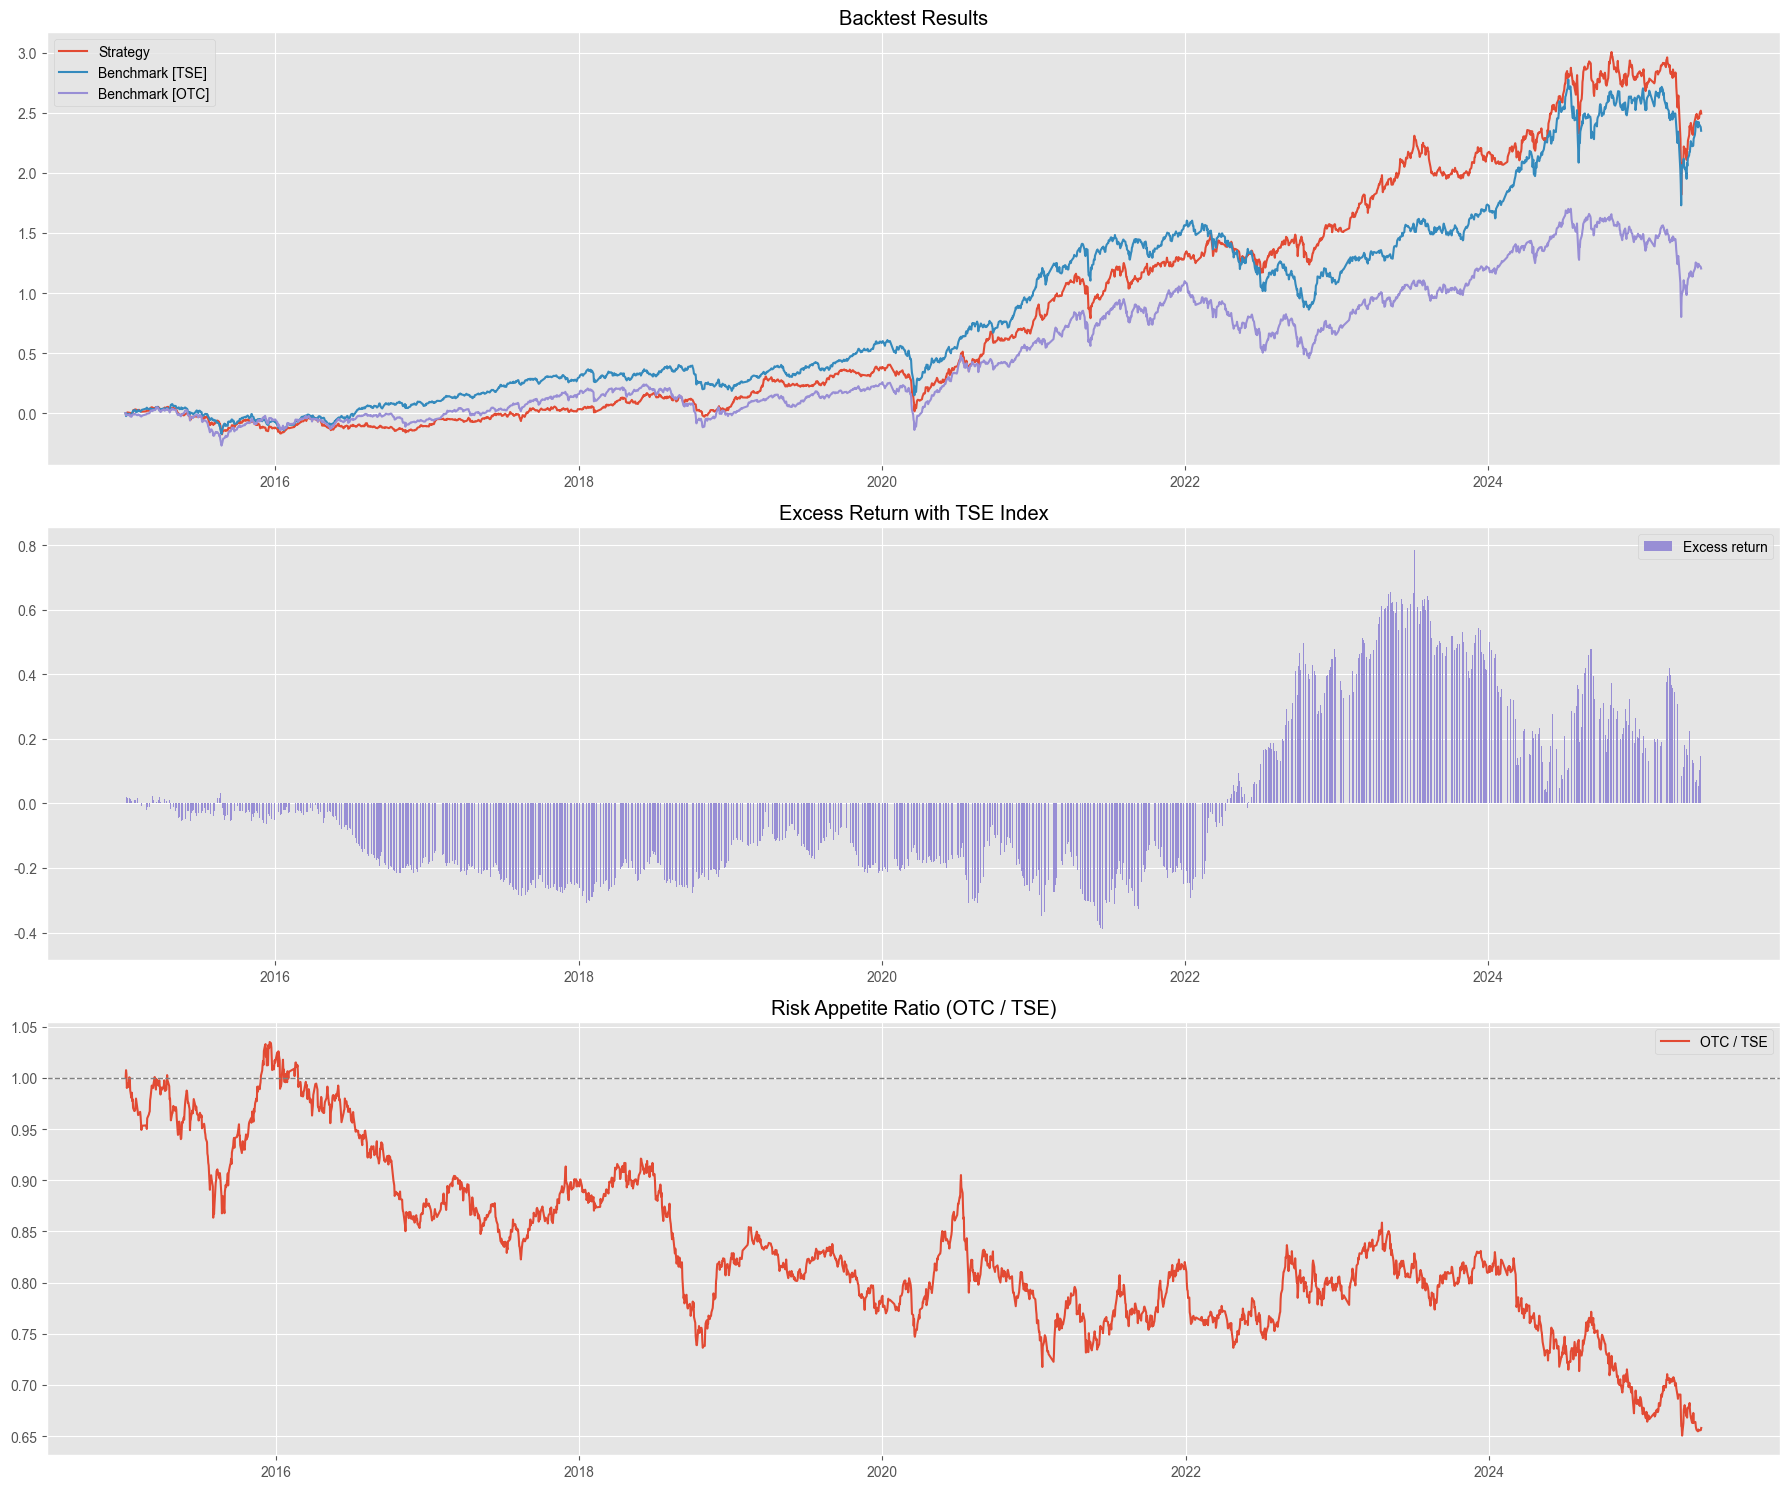

In [92]:
def analyze(context, perf):

  plt.style.use('ggplot')

  # 第一張圖：策略績效與報酬
  fig1, axes1 = plt.subplots(nrows=3, ncols=1, figsize=(18, 15), sharex=False)
  axes1[0].plot(perf.index, perf['algorithm_period_return'], label='Strategy')
  axes1[0].plot(merged['mdate'], (merged['TSE_norm'] / merged['TSE_norm'].iloc[0])-1, label='Benchmark [TSE]')
  axes1[0].plot(merged['mdate'], (merged['OTC_norm'] / merged['OTC_norm'].iloc[0])-1, label='Benchmark [OTC]')
  axes1[0].set_title("Backtest Results")
  axes1[0].legend()

  axes1[1].bar(perf.index, perf['algorithm_period_return'] - perf['benchmark_period_return'],
              label='Excess return', color='#988ED5', alpha = 1.0)
  axes1[1].set_title('Excess Return with TSE Index')
  axes1[1].legend()

  axes1[2].plot(merged['mdate'], merged['OTC_TSE_ratio'], label='OTC / TSE')
  axes1[2].set_title('Risk Appetite Ratio (OTC / TSE)')
  axes1[2].axhline(1.0, color='gray', linestyle='--', linewidth=1)
  axes1[2].legend()
  axes1[2].grid(True)

  plt.tight_layout()
  plt.show()

### 原本是 back_start end_date
results = run_algorithm(
            start = pd.Timestamp(back_start, tz = 'utc'),
            end = pd.Timestamp(end_date, tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_1,
            analyze = analyze,
            bundle = 'tquant',
            capital_base = 1e5)

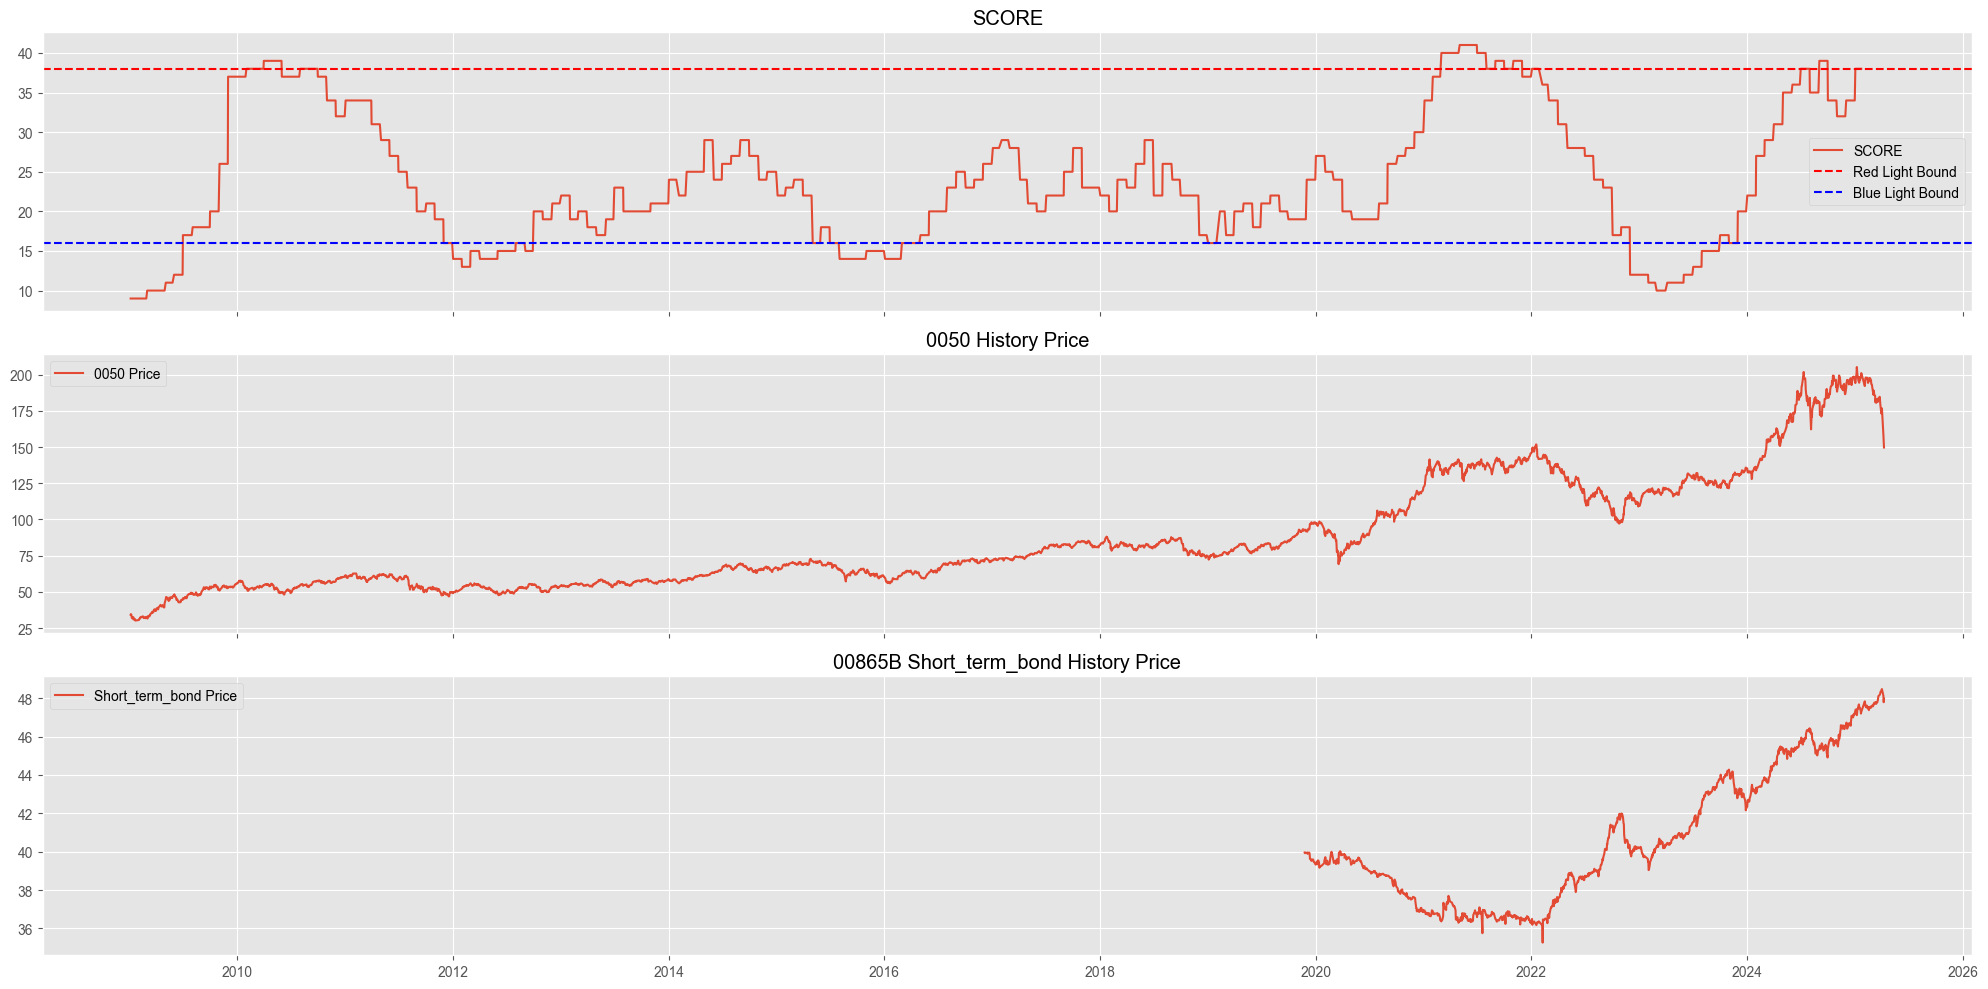

In [51]:
import pandas as pd

df = pd.read_csv('eco_data.csv')
df['mdate'] = pd.to_datetime(df['mdate'])
df['mdate'] = df['mdate'].dt.strftime('%Y-%m-%d')
df['mdate'] = pd.to_datetime(df['mdate'])


import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 10), sharex=True)
plt.style.use('ggplot')
axes[1].plot(df['mdate'], df['avgclsd'], label = '0050 Price')
axes[1].set_title(f'0050 History Price')
axes[1].legend()

axes[0].plot(df['mdate'], df['val_shifted'], label = 'SCORE')
axes[0].axhline(y = 38, label = 'Red Light Bound', color = 'red', linestyle = '--')
axes[0].axhline(y= 16, label = 'Blue Light Bound', color = 'blue', linestyle = '--')
axes[0].set_title(f'SCORE')
axes[0].legend()

axes[2].plot(df['mdate'], df['avgclsd_bond'], label = 'Short_term_bond Price')
axes[2].set_title(f'00865B Short_term_bond History Price')
axes[2].legend()

plt.tight_layout()
plt.show()

In [94]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

def rolling_alpha_beta(x, y, window):
    alpha_list = []
    beta_list = []

    for i in range(len(x)):
        if i < window:
            alpha_list.append(np.nan)
            beta_list.append(np.nan)
        else:
            x_window = y[i-window:i].values.reshape(-1, 1)
            y_window = x[i-window:i].values

            if np.isnan(x_window).any() or np.isnan(y_window).any():
                alpha_list.append(np.nan)
                beta_list.append(np.nan)
            else:
                model = LinearRegression()
                model.fit(x_window, y_window)
                beta_list.append(model.coef_[0])
                alpha_list.append(model.intercept_)

    return pd.Series(alpha_list, index=x.index), pd.Series(beta_list, index=x.index)


In [95]:
results_use = results.copy()
merged_use = merged.copy()

results_use['mdate'] = results_use['period_close'].copy()
results_use['mdate'] = pd.to_datetime(results_use['mdate'])
results_use['mdate'] = results_use['mdate'].dt.strftime('%Y-%m-%d')
results_use['mdate'] = pd.to_datetime(results_use['mdate'])

merged['mdate'] = pd.to_datetime(merged['mdate'])
merged['OTC_ret'] = merged['OTC_Close'].pct_change().fillna(0)
merged['TSE_ret'] = merged['TSE_Close'].pct_change().fillna(0)


merged_df = pd.merge(results_use, merged, on=['mdate'], how='left')

merged_df['strategy_ret'] = merged_df['returns']  # 依實際欄位名稱修改

st = merged_df['mdate'].iloc[0]
df_use = df[df['mdate'] >= st].copy()
# 用 OTC 為基準計算
alpha_otc, beta_otc = rolling_alpha_beta(
    x=merged_df['strategy_ret'],
    y=merged_df['OTC_ret'],
    window=60
)

# 用 TSE 為基準計算
alpha_tse, beta_tse = rolling_alpha_beta(
    x=merged_df['strategy_ret'],
    y=merged_df['TSE_ret'],
    window=60
)

# 存入主表
merged_df['alpha_OTC'] = alpha_otc
merged_df['beta_OTC'] = beta_otc
merged_df['alpha_TSE'] = alpha_tse
merged_df['beta_TSE'] = beta_tse


In [96]:
st = merged_df['mdate'].iloc[0]
df_use = df[df['mdate'] >= st].copy()
merged_df2 = pd.merge(merged_df.copy(), df_use, on=['mdate'], how='left')

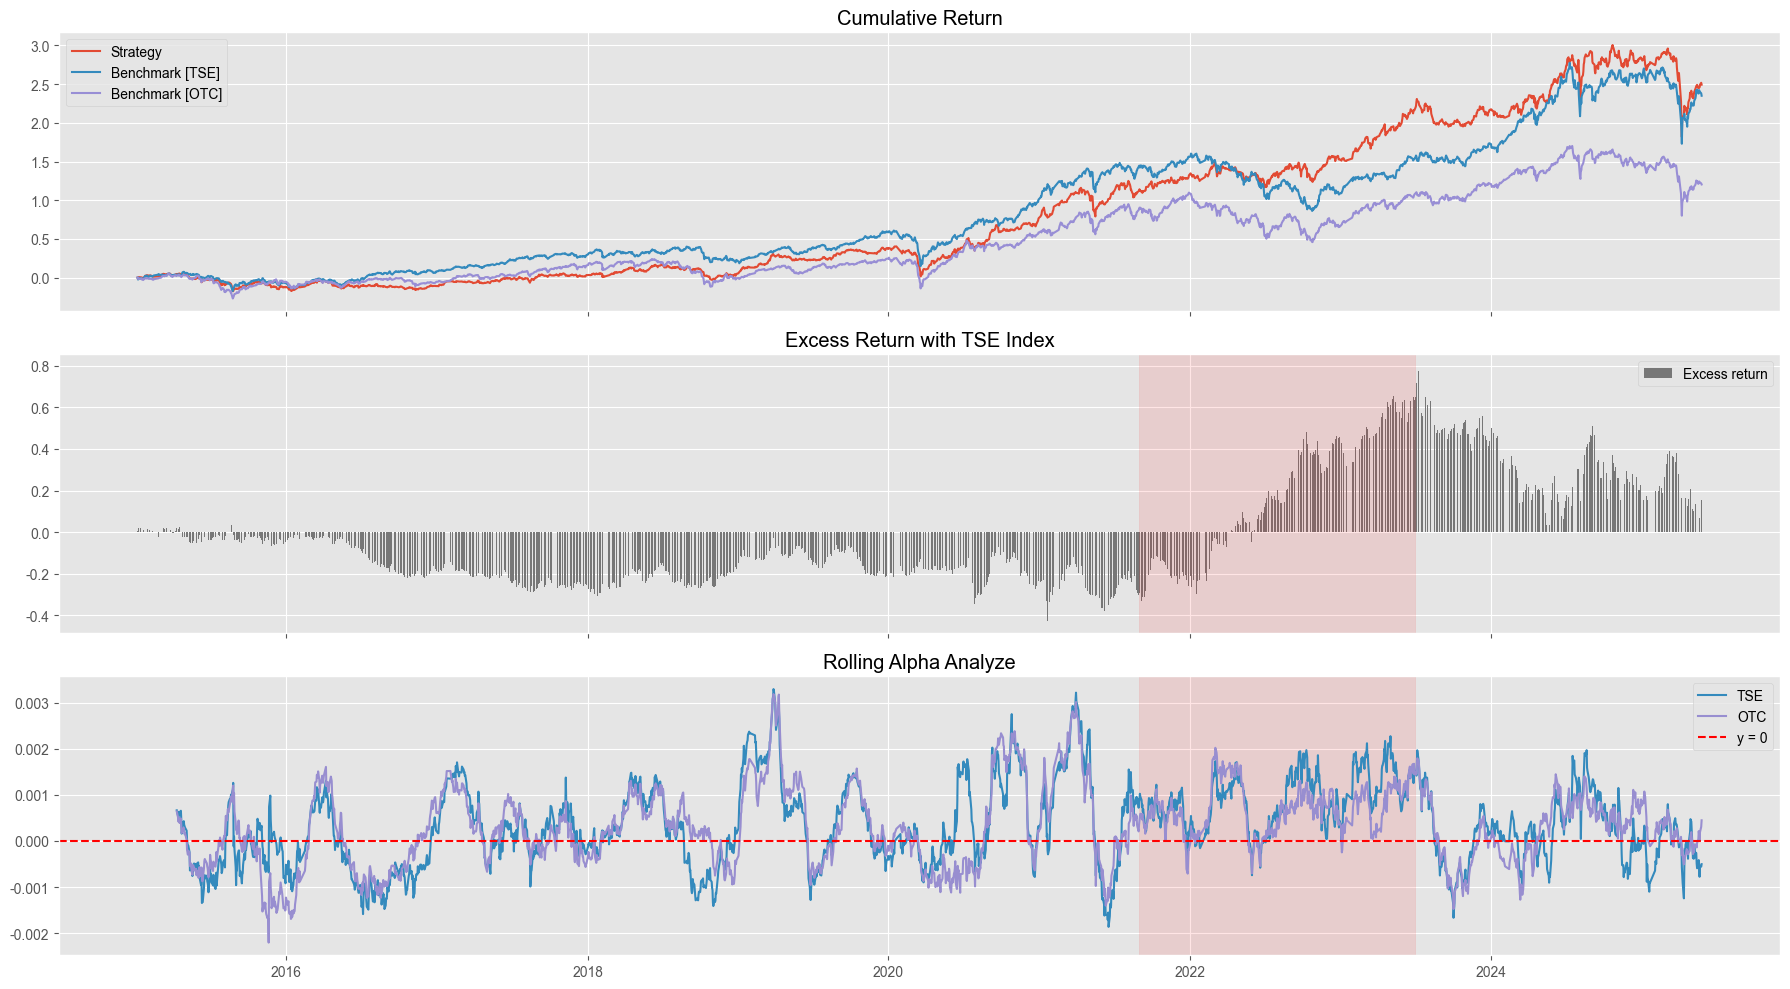

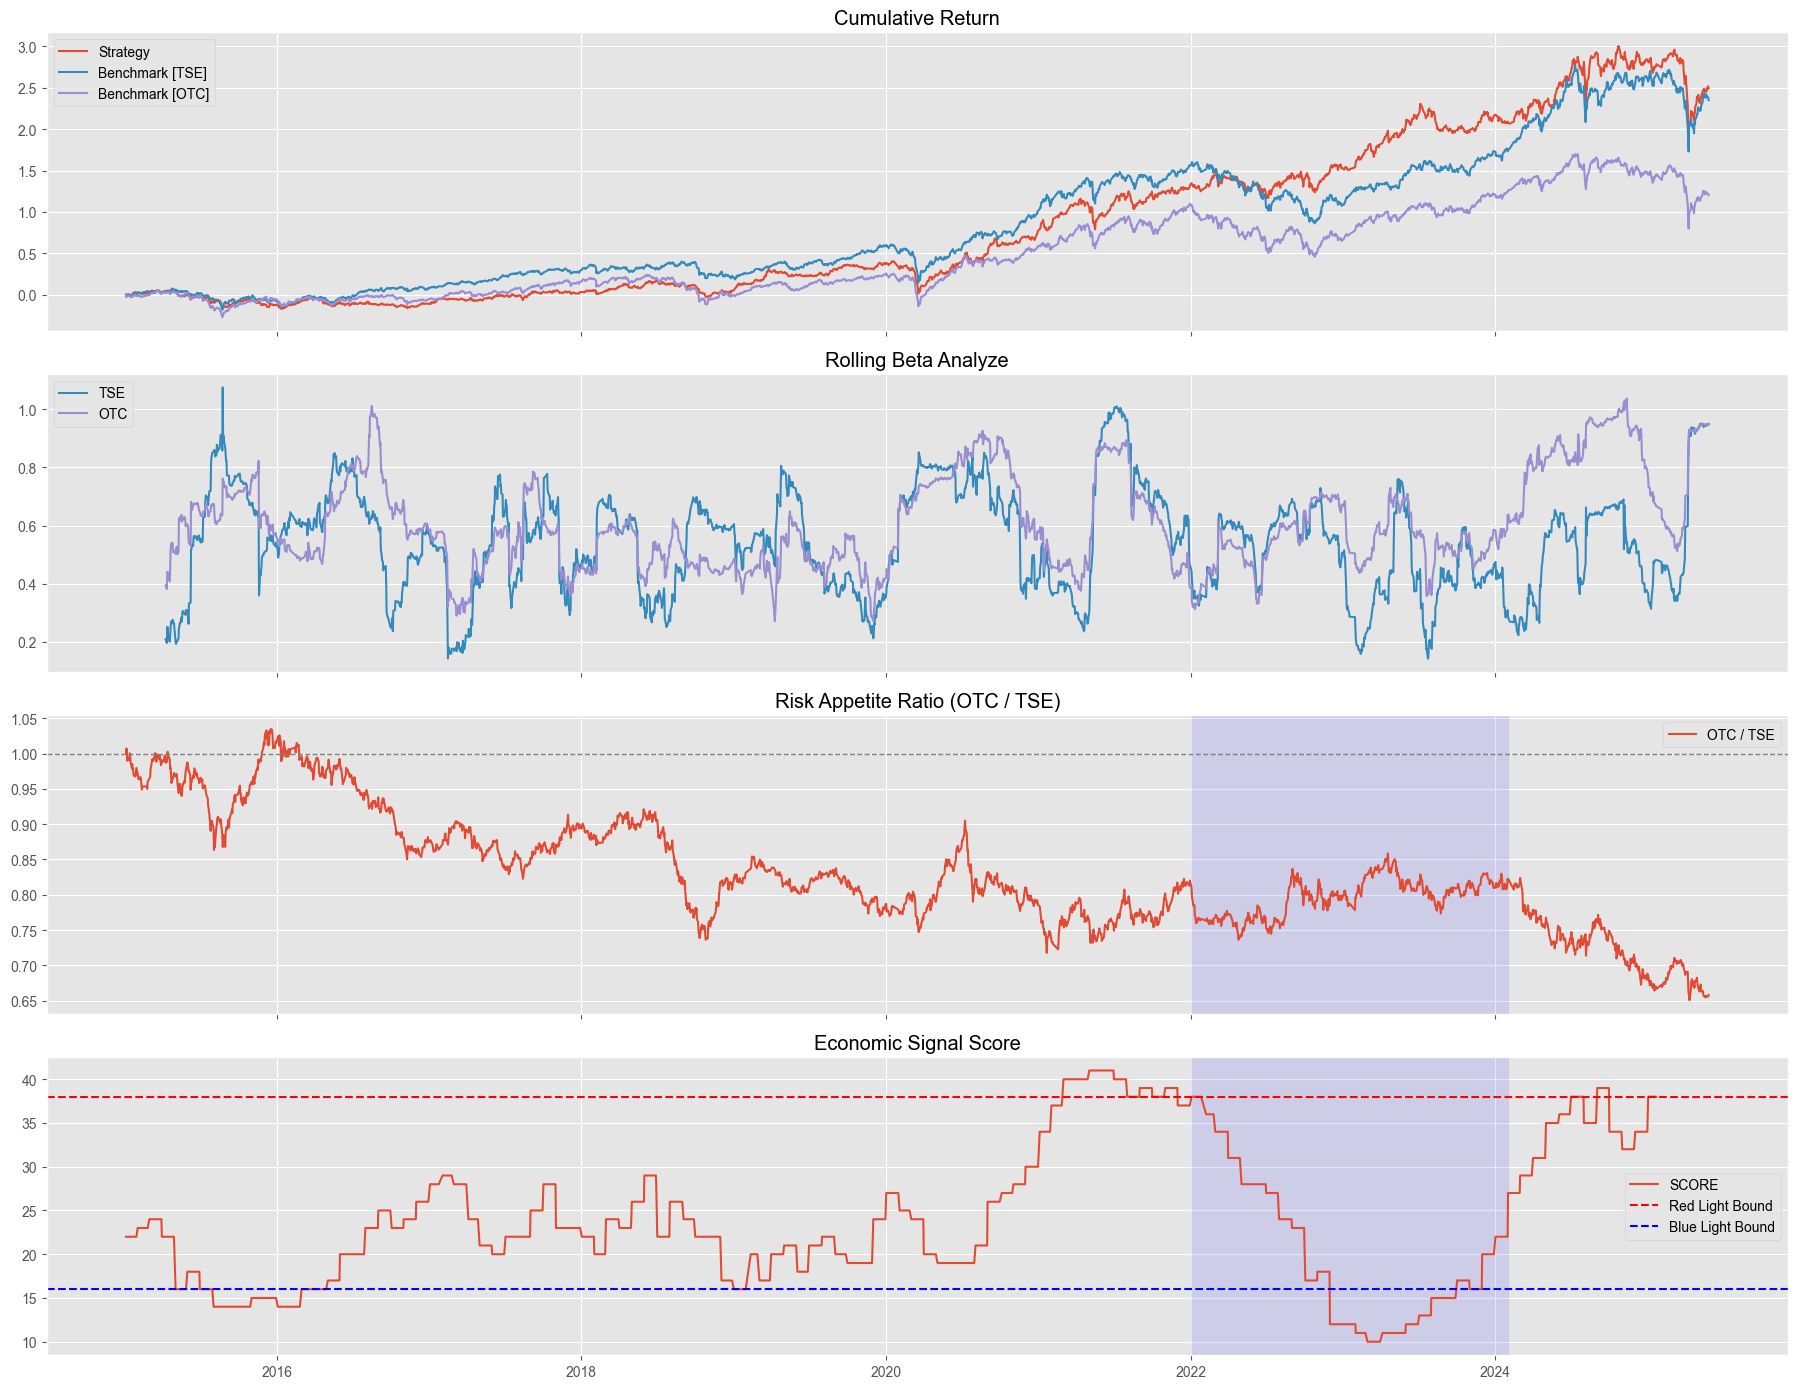

In [98]:
plt.style.use('ggplot')


highlight_start = pd.to_datetime('2021-09-01')
highlight_end = pd.to_datetime('2023-07-01')


fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(18, 10), sharex=True)
axes[0].plot(merged_df['mdate'], merged_df['algorithm_period_return'], label = 'Strategy')
axes[0].plot(merged_df['mdate'], (merged_df['TSE_norm'] / merged_df['TSE_norm'].iloc[0])-1, label='Benchmark [TSE]')
axes[0].plot(merged_df['mdate'], (merged_df['OTC_norm'] / merged_df['OTC_norm'].iloc[0])-1, label='Benchmark [OTC]')
axes[0].set_title(f'Cumulative Return')
axes[0].legend()

axes[1].bar(merged_df['mdate'], merged_df['algorithm_period_return'] - merged_df['benchmark_period_return'],
            label='Excess return', color='#777777', alpha = 1.0)
axes[1].axvspan(highlight_start, highlight_end, color='red', alpha=0.1)
axes[1].set_title('Excess Return with TSE Index')
axes[1].legend()

axes[2].plot(merged_df['mdate'], merged_df['alpha_TSE'], label = 'TSE', color = '#348ABD')
axes[2].plot(merged_df['mdate'], merged_df['alpha_OTC'], label = 'OTC', color = '#988ED0')
axes[2].axvspan(highlight_start, highlight_end, color='red', alpha=0.1)
axes[2].axhline(y = 0.0, color = 'red', linestyle = '--', label = 'y = 0')
axes[2].set_title(f'Rolling Alpha Analyze')
axes[2].legend()

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(18, 14), sharex=True)
highlight_start = pd.to_datetime('2022-01-01')
highlight_end = pd.to_datetime('2024-02-01')

# 圖一：累積報酬率（策略 vs TSE vs OTC）
axes[0].plot(merged_df2['mdate'], merged_df2['algorithm_period_return'], label='Strategy')
axes[0].plot(merged_df2['mdate'], (merged_df2['TSE_norm'] / merged_df2['TSE_norm'].iloc[0]) - 1, label='Benchmark [TSE]')
axes[0].plot(merged_df2['mdate'], (merged_df2['OTC_norm'] / merged_df2['OTC_norm'].iloc[0]) - 1, label='Benchmark [OTC]')
axes[0].set_title('Cumulative Return')
axes[0].legend()

# 圖二：Rolling Beta（TSE vs OTC）
axes[1].plot(merged_df2['mdate'], merged_df2['beta_TSE'], label='TSE', color='#348ABD')
axes[1].plot(merged_df2['mdate'], merged_df2['beta_OTC'], label='OTC', color='#988ED0')
axes[1].set_title('Rolling Beta Analyze')
axes[1].legend()

# 圖三：OTC/TSE 風險偏好比值
axes[2].plot(merged_df2['mdate'], merged_df2['OTC_TSE_ratio'], label='OTC / TSE')
axes[2].axhline(1.0, color='gray', linestyle='--', linewidth=1)
axes[2].axvspan(highlight_start, highlight_end, color='blue', alpha=0.1)
axes[2].set_title('Risk Appetite Ratio (OTC / TSE)')
axes[2].legend()
axes[2].grid(True)

# 圖四：景氣燈號 SCORE
axes[3].plot(merged_df2['mdate'], merged_df2['val_shifted'], label='SCORE')
axes[3].axhline(y=38, label='Red Light Bound', color='red', linestyle='--')
axes[3].axhline(y=16, label='Blue Light Bound', color='blue', linestyle='--')
axes[3].axvspan(highlight_start, highlight_end, color='blue', alpha=0.1)
axes[3].set_title('Economic Signal Score')
axes[3].legend()



plt.tight_layout()
plt.show()


Start date,2015-01-05
End date,2025-05-27
Total months,120
,Backtest
Annual return,13.257%
Cumulative returns,249.329%
Annual volatility,16.609%
Sharpe ratio,0.83
Calmar ratio,0.45
Stability,0.93
Max drawdown,-29.674%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.67,2024-10-23,2025-04-09,NaT,NaN
1,27.63,2020-01-20,2020-03-19,2020-07-02,106
2,21.75,2015-04-17,2015-08-25,2017-11-03,629
3,17.12,2021-04-12,2021-05-17,2021-07-06,60
4,16.85,2018-07-02,2018-10-30,2019-02-20,158


Top 10 long positions of all time,max
sid,
3086,14.42%
2442,13.13%
6231,12.33%
8931,12.14%
5234,12.12%
2438,11.93%
3570,11.87%
5210,11.84%
1467,11.84%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3086,14.42%
2442,13.13%
6231,12.33%
8931,12.14%
5234,12.12%
2438,11.93%
3570,11.87%
5210,11.84%
1467,11.84%


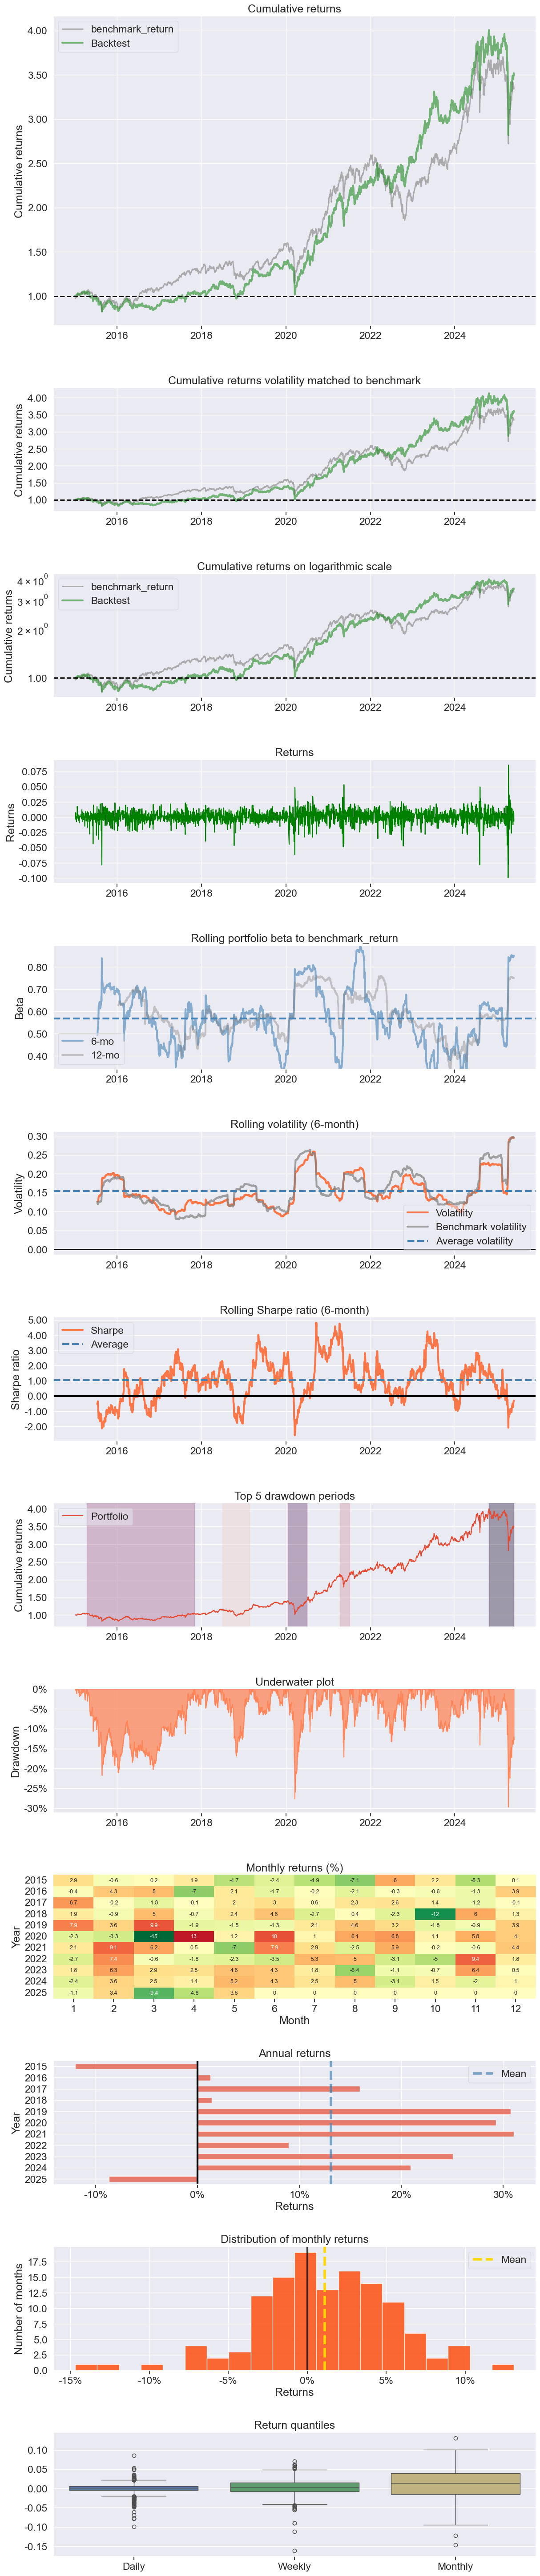

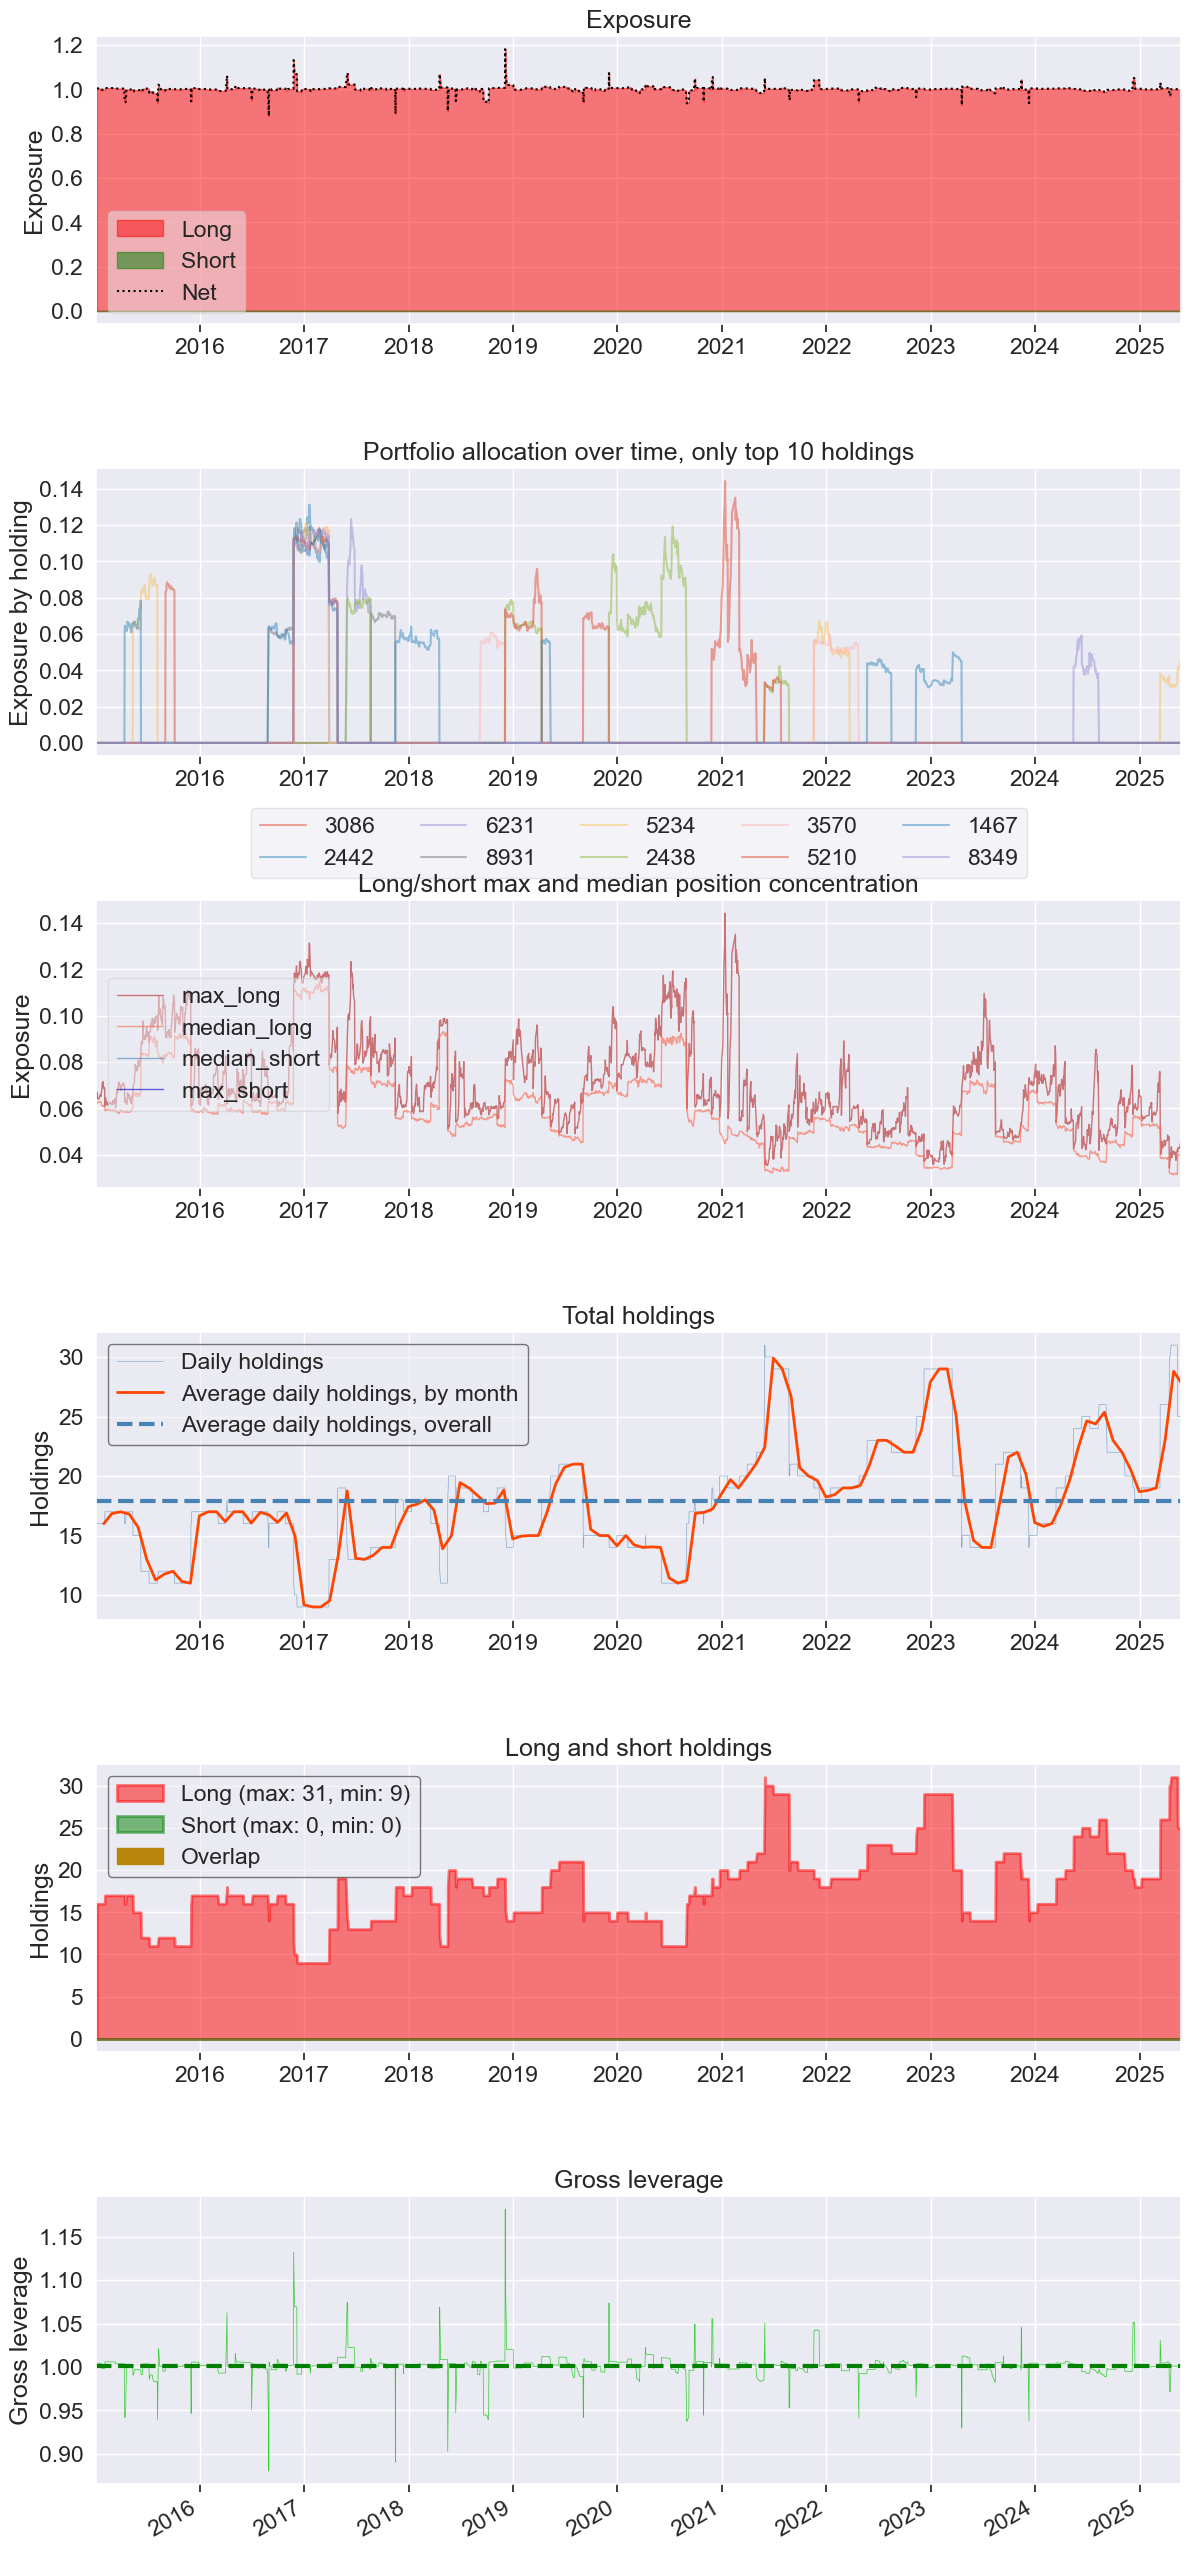

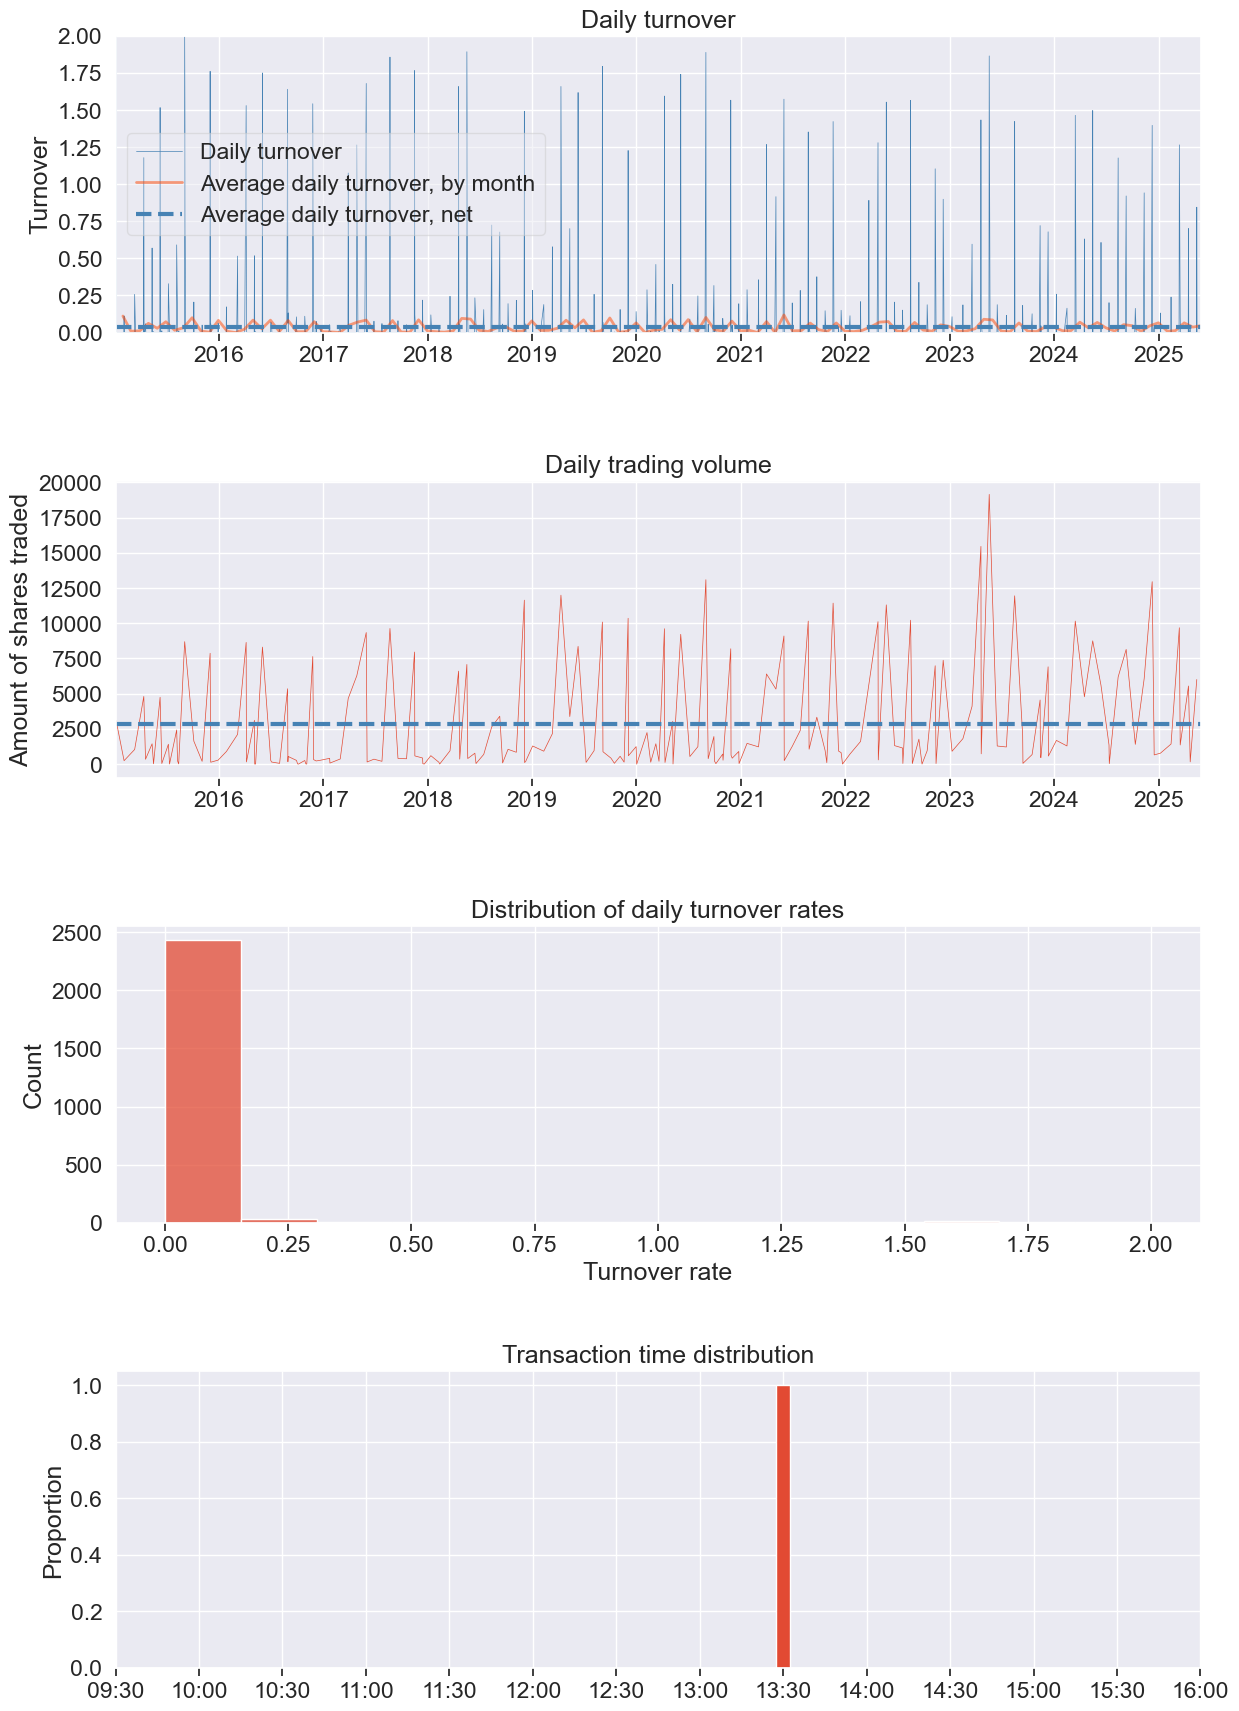

In [93]:
import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return
pyfolio.tears.create_full_tear_sheet(returns=returns,
                                     positions=positions,
                                     transactions=transactions,
                                     benchmark_rets=benchmark_rets
                                    )

In [10]:
def handle_data_tse(context, data):
    if context.i == 0:
        order_target_percent(symbol('IR0001'), 1.0)

    context.i += 1


def handle_data_otc(context, data):
    if context.i == 0:
        order_target_percent(symbol('IR0043'), 1.0)

    context.i += 1

def ana(context, perf):
    pass



In [11]:
results_tse = run_algorithm(
            start = pd.Timestamp(back_start, tz = 'utc'),
            end = pd.Timestamp(end_date, tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_tse,
            analyze = ana,
            bundle = 'tquant',
            capital_base = 1e5)

import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns_tse, positions, transactions = extract_rets_pos_txn_from_zipline(results_tse)
benchmark_rets = results_tse.benchmark_return

from pyfolio.plotting import show_perf_stats
perf_stats = show_perf_stats(
    returns_tse, 
    benchmark_rets, 
    positions, 
    transactions,   
)



Start date,2015-01-05
End date,2025-05-27
Total months,120
,Backtest
Annual return,12.771%
Cumulative returns,234.561%
Annual volatility,16.665%
Sharpe ratio,0.81
Calmar ratio,0.45
Stability,0.94
Max drawdown,-28.097%


In [12]:
results_otc = run_algorithm(
            start = pd.Timestamp(back_start, tz = 'utc'),
            end = pd.Timestamp(end_date, tz = 'utc'),
            initialize = initialize,
            handle_data = handle_data_otc,
            analyze = ana,
            bundle = 'tquant',
            capital_base = 1e5)

import pyfolio
from pyfolio.utils import extract_rets_pos_txn_from_zipline
plt.rcParams['font.sans-serif'] = ['Arial', 'Noto Sans CJK TC', 'SimHei']  
plt.rcParams['axes.unicode_minus'] = False  
returns, positions, transactions = extract_rets_pos_txn_from_zipline(results_otc)
benchmark_rets = results_otc.benchmark_return

from pyfolio.plotting import show_perf_stats
perf_stats = show_perf_stats(
    returns, 
    benchmark_rets, 
    positions, 
    transactions,   
)

Start date,2015-01-05
End date,2025-05-27
Total months,120
,Backtest
Annual return,8.248%
Cumulative returns,121.744%
Annual volatility,18.703%
Sharpe ratio,0.52
Calmar ratio,0.25
Stability,0.90
Max drawdown,-33.137%
